In [7]:
import torch
from torch.distributions import Normal, Gamma
from torch.distributions.log_normal import LogNormal

import numpy as np
import matplotlib.pyplot as plt
import datetime

import advi
import Timer

# Set default type to float64 (instead of float32)
torch.set_default_dtype(torch.float64)

In [8]:
def log_prior_plus_logabsdet_J(real_params, params):
    # log prior for beta, evaluated at sampled values for beta
    lp_b = Normal(0, 1).log_prob(real_params['beta']).sum()

    # log prior sig + log jacobian
    lp_log_sig = (Gamma(1, 1).log_prob(params['sig']) + real_params['sig']).sum()

    return lp_b + lp_log_sig

def loglike(y, x, params, full_data_size):
    beta = params['beta']
    sig = params['sig']
    return Normal(x.matmul(beta), sig).log_prob(y).mean(0) * full_data_size

def log_q(model_params, real_params):
    out = 0.0
    for key in model_params:
        out += model_params[key].log_q(real_params[key])
    return out

def elbo(y, x, model_params, full_data_size):
    real_params = {}
    for key in model_params:
        real_params[key] = model_params[key].rsample()

    params = {'beta': real_params['beta'],
              'sig': real_params['sig'].exp()}

    out = loglike(y, x, params, full_data_size)
    out += log_prior_plus_logabsdet_J(real_params, params) 
    out -= log_q(model_params, real_params)

    return out

In [9]:
# set random number generator seeds for reproducibility
torch.manual_seed(1)
np.random.seed(0)

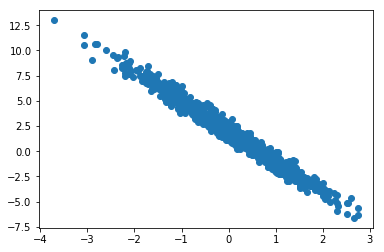

In [10]:
# Generate data
N = 1000
x = torch.stack([torch.ones(N), torch.randn(N)], -1)
k = x.shape[1]
beta = torch.tensor([2., -3.])
sig = 0.5
y = Normal(x.matmul(beta), sig).rsample()

# Plot data
plt.scatter(x[:, 1].numpy(), y.numpy()); plt.show()

In [11]:
model_params = {'beta': advi.ModelParam(size=k), 'sig': advi.ModelParam(size=1)}
optimizer = torch.optim.Adam([model_params[key].vp for key in model_params], lr=.1)
elbo_hist = []

max_iter = 1000
minibatch_size = 100
torch.manual_seed(1)
with Timer.Timer('LinReg'):
    for t in range(max_iter):
        sample_with_replacement = minibatch_size > N
        idx = np.random.choice(N, minibatch_size, replace=sample_with_replacement)
        loss = -elbo(y[idx], x[idx, :], model_params, full_data_size=N) / N
        elbo_hist.append(-loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (t + 1) % (max_iter / 10) == 0:
            now = datetime.datetime.now()
            print('{} | {}/{} | elbo: {}'.format(now, t + 1, max_iter, elbo_hist[-1]))

2019-02-25 22:10:21.921759 | 100/1000 | elbo: -2.6591570381372955
2019-02-25 22:10:22.042322 | 200/1000 | elbo: -1.9178960830274894
2019-02-25 22:10:22.172639 | 300/1000 | elbo: -1.0809662443934889
2019-02-25 22:10:22.298342 | 400/1000 | elbo: -1.066108971341221
2019-02-25 22:10:22.420524 | 500/1000 | elbo: -0.8663142299367079
2019-02-25 22:10:22.530850 | 600/1000 | elbo: -0.9788739108056087
2019-02-25 22:10:22.656989 | 700/1000 | elbo: -0.7890816868714304
2019-02-25 22:10:22.777257 | 800/1000 | elbo: -0.7588138921161178
2019-02-25 22:10:22.903715 | 900/1000 | elbo: -0.787416569401845
2019-02-25 22:10:23.027662 | 1000/1000 | elbo: -0.7778341854372927
LinReg time: 1s


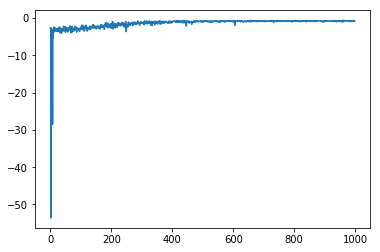

sig mean: 0.5305617416375544 | sig sd: 0.07486571057122324
beta mean: [ 1.9040693  -2.96134387]
beta sd: [0.0633083  0.02727116]


In [12]:
# Inspect posterior
nsamps = 1000

plt.plot(elbo_hist)
plt.show()

sig_post = model_params['sig'].rsample([nsamps]).exp().detach().numpy()
print('sig mean: {} | sig sd: {}'.format(sig_post.mean(), sig_post.std()))
print('beta mean: {}'.format(model_params['beta'].vp[0].detach().numpy()))
print('beta sd: {}'.format(model_params['beta'].vp[1].exp().detach().numpy()))